In [ ]:
!pip install neptune-client

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm

import torchvision

import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

import math
import copy

import neptune.new as neptune

In [5]:
path = '../../../data/birds/train/'
def show_image(data_dir=path):
    list_dir = os.listdir(data_dir)
    rand_d = np.random.randint(0, len(list_dir))
    rand_d = list_dir[rand_d]
    img_dir = data_dir+rand_d
    image = os.listdir(img_dir)
    rand_i = np.random.randint(len(image))
    img_src = img_dir+'/'+image[rand_i]
    img = cv2.imread(img_src)
    resize = cv2.resize(img, (100,100))
    plt.figure(figsize=(10,8))
    plt.imshow(img)
    plt.title(rand_d)
    
    
    plt.axis('off')
    plt.show()

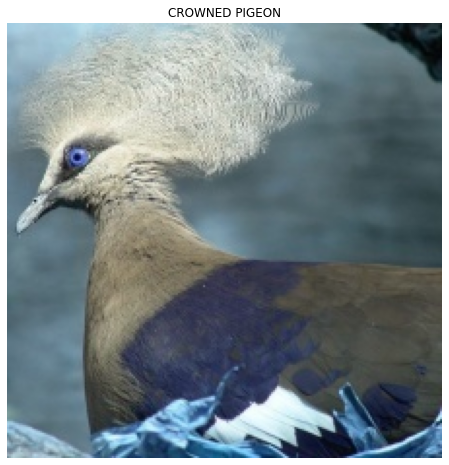

In [6]:
show_image()

# Create Dataset

In [7]:
train_dir = '../../../data/birds/train/'
val_dir = '../../../data/birds/valid/'
test_dir = '../../../data/birds/test/'

bs = 4
crop_size = 128

def dataset(bs, crop_size, sample_size='full'):
    transformations = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(crop_size),
        torchvision.transforms.CenterCrop(crop_size),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    
    
    if sample_size == 'full':
        train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=transformations)
        valid_data = torchvision.datasets.ImageFolder(root=val_dir, transform=transformations)
        test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=transformations)
        
        train_data = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=bs)
        valid_data = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=bs)
        test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=bs)
    
    else:
        train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=transformations)
        indices = torch.arange(sample_size)
        train_data = torch.utils.data.Subset(train_data, indices)
        train_data = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=bs)
    
    
    valid_data = torchvision.datasets.ImageFolder(root=val_dir, transform=transformations)    
    valid_data = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=bs)
    
    test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=transformations)
    test_data = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=bs)
    
    return train_data, valid_data, test_data

# Data Modeling

In [8]:
from torch.nn.modules.utils import _pair
class Embeddings(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, img_size:int, hidden_size:int, 
                 in_channels:int
                ):
        
        super(Embeddings, self).__init__()
        img_size = _pair(img_size)
        
        patch_size = _pair(img_size)
        n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        
        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=hidden_size,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches+1, hidden_size))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_size))

        self.dropout = Dropout(0.1)

    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)

        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        x = torch.cat((cls_tokens, x), dim=1)

        embeddings = x+self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings

In [9]:
class Attention(nn.Module):
    def __init__(self, num_attention_heads, hidden_size, attention_dropout_rate):
        super(Attention, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(hidden_size, self.all_head_size)
        self.key = Linear(hidden_size, self.all_head_size)
        self.value = Linear(hidden_size, self.all_head_size)

        self.out = Linear(hidden_size, self.all_head_size)
        self.attn_dropout = Dropout(attention_dropout_rate)
        self.proj_dropout = Dropout(attention_dropout_rate)

        self.softmax = torch.nn.Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs 
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights


In [10]:
class Mlp(nn.Module):
    def __init__(self, hidden_size, linear_dim, dropout_rate, std_norm):
        super(Mlp, self).__init__()
        self.fc1 = Linear(hidden_size, linear_dim)
        self.fc2 = Linear(linear_dim, hidden_size)
        self.act_fn = torch.nn.functional.gelu
        self.dropout = Dropout(dropout_rate)
        self.std_norm = std_norm
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=self.std_norm)
        nn.init.normal_(self.fc2.bias, std=self.std_norm)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x
    

In [12]:
class Block(nn.Module):
    def __init__(self, num_attention_heads, hidden_size, linear_dim, dropout_rate,
                 attention_dropout_rate, eps, std_norm):
        
        super(Block, self).__init__()
        self.hidden_size = hidden_size
        self.attention_norm = LayerNorm(hidden_size, eps=eps)
        self.ffn_norm = LayerNorm(hidden_size, eps=eps)
        self.ffn = Mlp(hidden_size=hidden_size, linear_dim=linear_dim,
                       dropout_rate=dropout_rate, std_norm=std_norm)
        self.attn = Attention(num_attention_heads=num_attention_heads,
                              hidden_size=hidden_size,
                              attention_dropout_rate=attention_dropout_rate)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h
        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights

In [13]:
class Encoder(nn.Module):
    def __init__(self, num_layers, 
                       hidden_size, 
                       num_attention_heads,
                       linear_dim, 
                       dropout_rate,
                       attention_dropout_rate, 
                       eps, 
                       std_norm):
        super(Encoder, self).__init__()
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(hidden_size, eps=eps)
        for _ in range(num_layers):
            layer = Block(num_attention_heads, hidden_size, linear_dim, dropout_rate,
                          attention_dropout_rate, eps, std_norm)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights
    


In [14]:
class Transformer(nn.Module):
    def __init__(self, 
                 img_size,
                 hidden_size,
                 in_channels,
                 num_layers,
                 num_attention_heads,
                 linear_dim,
                 dropout_rate,
                 attention_dropout_rate,
                 eps,
                 std_norm):
        super(Transformer, self).__init__()
        self.embeddings = Embeddings(img_size, 
                                     hidden_size, 
                                     in_channels)
        
        self.encoder = Encoder(num_layers, 
                               hidden_size, 
                               num_attention_heads,  
                               linear_dim=config.LINEAR_DIM, 
                               dropout_rate=config.DROPOUT_RATE,
                               attention_dropout_rate=config.ATTENTION_DROPOUT_RATE, 
                               eps=config.EPS, 
                               std_norm=config.STD_NORM)

    def forward(self, input_ids):
        embedding_output = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)
        return encoded, attn_weights

In [15]:
class VisionTransformer(nn.Module):
    def __init__(self, 
                 img_size,
                 num_classes,
                 hidden_size,
                 in_channels,
                 num_layers,
                 num_attention_heads,
                 linear_dim,
                 dropout_rate,
                 attention_dropout_rate,
                 eps,
                 std_norm):
        super(VisionTransformer, self).__init__()
        self.classifier = 'token'

        self.transformer=Transformer(img_size,
                                     hidden_size,
                                     in_channels,
                                     num_layers,
                                     num_attention_heads,
                                     linear_dim,
                                     dropout_rate,
                                     attention_dropout_rate,
                                     eps,
                                     std_norm)
        self.head = Linear(hidden_size, num_classes)

    def forward(self, x, labels=None):
        x, attn_weights = self.transformer(x)
        logits = self.head(x[:, 0])

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 400), labels.view(-1))
            return loss
        else:
            return logits, attn_weights

In [16]:
def train_Engine(n_epochs,
                 train_data,
                 val_data,
                 model,
                 optimizer,
                 loss_fn,
                 device,
                 monitoring=True):

    logits_m = []
    yo = []
    attention = []
    
    best_accuracy = 0
    for epoch in range(1, n_epochs + 1):
        print('Epoch:', epoch)
        for i, (data, target) in tqdm(enumerate(train_data), total=len(train_data), desc="Training"):
            total_samples = len(train_data.dataset)
            best_accuracy = 0
            #device
            model = model.to(device)
            x = data.to(device)
            y = target.to(device)
            optimizer.zero_grad()
            
            logits, attn_weights = model(x)
            proba = F.log_softmax(logits, dim=1)
            loss = F.nll_loss(proba, y, reduction='sum')
            loss.backward()
            
            yhat = torch.argmax(logits, dim=1)
            accuracy = torch.sum(yhat == y).item()/len(train_data)            
            optimizer.step()
            
            if monitoring:
                run['Training_loss'].log(loss.item())
                run['Training_acc'].log(accuracy)

            if accuracy > best_accuracy:
                best_model = model
                torch.save(best_model, 'model.pth')
        
        model.eval()
        total_samples = len(val_data.dataset)
        correct_samples = 0
        total_loss = 0
        
        with torch.no_grad():
            for i, (data, target) in tqdm(enumerate(val_data), total=len(val_data), desc="Evaluation"):
                
                model = model.to(device)
                x = data.to(device)
                y = target.to(device)
            
                logits,attn_weights = model(x)
                proba = F.log_softmax(logits, dim=1)
                val_loss = F.nll_loss(proba, y, reduction='sum')
                _, pred = torch.max(logits, dim=1)
                

                for t, p in zip(y.view(-1), pred.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

                
                total_loss += val_loss.item()
                correct_samples += pred.eq(y).sum()
                val_acc = torch.sum(pred == y).item()/len(val_data)
                avg_loss = total_loss / total_samples

                if monitoring:
                    run['Val_loss'].log(avg_loss)
                    run['Val_accuracy'].log(val_acc)
    
    return confusion_matrix, logits_m, yo, attention

In [17]:
class Config:
    #Image configuration
    IMG_SIZE = 128
    PATCH_SIZE = 10
    CROP_SIZE = 100
    BATCH_SIZE = 1
    DATASET_SAMPLE = 'full'


    #opimizer configuration
    LR = 0.003
    OPIMIZER = 'Adam'

    #Model configuration
    NUM_CLASSES = 400
    IN_CHANNELS = 3
    HIDDEN_SIZE = 768
    NUM_ATTENTION_HEADS = 12
    LINEAR_DIM = 3072
    NUM_LAYERS = 12
    
    ATTENTION_DROPOUT_RATE = 0.1
    DROPOUT_RATE = 0.1
    STD_NORM = 1e-6
    EPS = 1e-6
 
    MPL_DIM = 128
    OUTPUT = 'softmax'
    LOSS_FN = 'nll_loss'


    #Device configuration
    DEVICE = ["cpu","mps","cuda"]

# Config.__dict__
config = Config()


x = torch.randn(1,config.IN_CHANNELS*config.IMG_SIZE*config.IMG_SIZE)
x = x.reshape(1,config.IN_CHANNELS,config.IMG_SIZE,config.IMG_SIZE)

model = VisionTransformer(img_size=config.IMG_SIZE,
                 num_classes=config.NUM_CLASSES,
                 hidden_size=config.HIDDEN_SIZE,
                 in_channels=config.IN_CHANNELS,
                 num_layers=config.NUM_LAYERS,
                 num_attention_heads=config.NUM_ATTENTION_HEADS,
                 linear_dim=config.LINEAR_DIM,
                 dropout_rate=config.DROPOUT_RATE,
                 attention_dropout_rate=config.ATTENTION_DROPOUT_RATE,
                 eps=config.EPS,
                 std_norm=config.STD_NORM)

optimizer = optim.Adam(model.parameters(), lr=0.003)

run = neptune.init(
    project="nielspace/ViT-bird-classification",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkYjRhYzI0Ny0zZjBmLTQ3YjYtOTY0Yi05ZTQ4ODM3YzE0YWEifQ==",
)
logits, attn_weights = model(x)

https://app.neptune.ai/nielspace/ViT-bird-classification/e/VIT-26


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [24]:
train_data, val_data, test_data = dataset(config.BATCH_SIZE,config.IMG_SIZE, config.DATASET_SAMPLE)
# confusion_matrix, logits, y, attention = train_Engine(n_epochs=500,
#              train_data=train_data,
#              val_data=val_data,
#              model=model,
#              optimizer=optimizer,
#              loss_fn='nll_loss',
#              device=config.DEVICE[2], monitoring=True)

In [100]:
test_data

2000

In [ ]:
m = torch.load('model.pth')

total_samples =len(val_data.dataset)
correct_samples = 0
total_loss = 0

confusion_matrix = torch.zeros(400, 400)

for i, (data, target) in tqdm(enumerate(test_data), total=len(test_data), desc="Testing"):           
    model = m.to('mps')
    x = data.to('mps')
    y = target.to('mps')

    logits, attn_weights = model(x)
    proba = F.log_softmax(logits, dim=1)
    val_loss = F.nll_loss(proba, y, reduction='sum')
    _, pred = torch.max(logits, dim=1)
    
    total_loss += val_loss.item()
    correct_samples += pred.eq(y).sum()
    val_acc = torch.sum(pred == y).item()/len(val_data)
    avg_loss = total_loss / total_samples
    
    for t, p in zip(y.view(-1), pred.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1
    
    if i == 50:
        break

In [ ]:
# probs = torch.zeros(len(logits))
# y_ = torch.zeros(len(y))
# idx = 0
# for l, o in zip(logits, y):
#     l = F.softmax(l, dim=0)
#     print(l)
#     break
# #     probs[idx] = l.item()
# #     y_[idx] = o
# #     idx+=1

In [ ]:
# probs.to(torch.long).numpy().shape

In [ ]:
from sklearn.metrics import (precision_score, recall_score, f1_score, roc_auc_score, 
#                              roc_curve, precision_recall_curve, classification_report, cohen_kappa_score)

In [ ]:
# print(cohen_kappa_score(y_.to(torch.long).numpy(), probs.to(torch.long).numpy()))

In [ ]:
# print(classification_report(y_.to(torch.long).numpy(), probs.to(torch.long).numpy()))

In [ ]:
# roc_auc_score(y_.to(torch.long).numpy(), probs.to(torch.long).numpy(), average='micro', multi_class='ovr')

In [ ]:
# precision_score(y_.to(torch.long).numpy(), probs.to(torch.long).numpy(), average='micro')

In [ ]:
# f1_score(y_.to(torch.long).numpy(), probs.to(torch.long).numpy(), average='micro')

In [ ]:
# recall_score(y_.to(torch.long).numpy(), probs.to(torch.long).numpy(), average='micro')

In [ ]:
# run["parameters"] = params

# for epoch in range(10):
#     run["train/loss"].log(0.9 ** epoch)

# run["eval/f1_score"] = 0.66

# run.stop()

In [ ]:
# PARAMS = {}
# for key, val in Config.__dict__.items():
#     if key not in ['__module__', '__dict__', '__weakref__', '__doc__']:
#         PARAMS[key] = val
        
# PARAMS

In [23]:
t

'../../../data/birds/test/'

In [33]:
logits, att = model(next(iter(test_data))[0].to('mps'))

In [34]:
prob = torch.nn.functional.softmax(logits, dim = 1)[0] * 100

In [41]:
classes = test_data.dataset.classes

In [42]:
_, indices = torch.sort(logits.cpu(), descending = True)
[(classes[idx], prob[idx].item()) for idx in indices[0][:5]]

[('ABBOTTS BABBLER', 0.0),
 ('ABBOTTS BOOBY', 0.0),
 ('ABYSSINIAN GROUND HORNBILL', 0.0),
 ('AFRICAN CROWNED CRANE', 0.0),
 ('AFRICAN EMERALD CUCKOO', 0.0)]

In [47]:
print(f'hi {0.23795:.2f}')

hi 0.24


# Attention Maps

In [88]:
from PIL import Image
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

im = Image.open('../../../data/birds/train/ABBOTTS BABBLER/001.jpg')
x = transform(im)
x.size()

torch.Size([3, 128, 128])

In [89]:
att_mat = torch.stack(att).squeeze(1)
# # Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# # To account for residual connections, we add an identity matrix to the
# # attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat.cpu() + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# # Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# # Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()


mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

/var/folders/2y/zn4cnbc11vj85_hwhqwqcg7c0000gn/T/ipykernel_78490/2666732399.py:24: RuntimeWarning: invalid value encountered in true_divide
  mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]


Prediction Label and Attention Map!

0.00250 : ABBOTTS BABBLER0.00250 : ABBOTTS BOOBY0.00250 : ABYSSINIAN GROUND HORNBILL0.00250 : AFRICAN CROWNED CRANE0.00250 : AFRICAN EMERALD CUCKOO

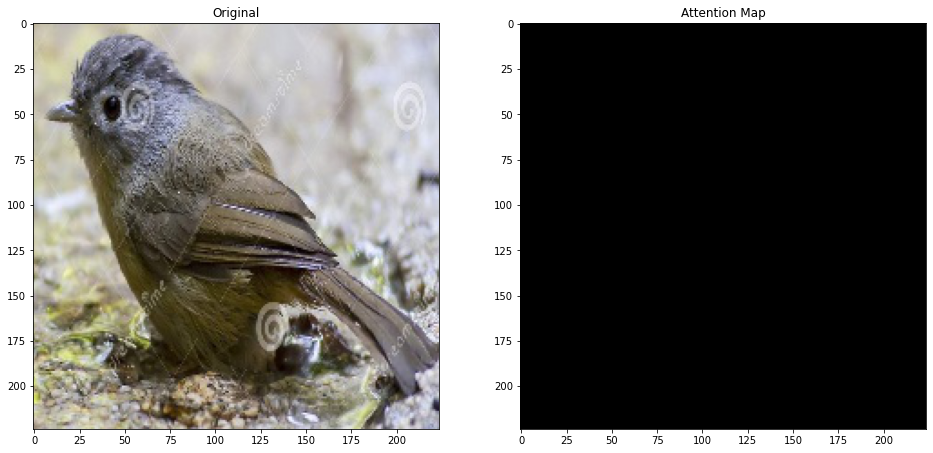

Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterTimeout
Communication with Neptune restored!


In [95]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs.cpu(), dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {classes[idx.item()]}', end='')

tensor(0., device='mps:0', grad_fn=<SelectBackward0>)